In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory

# GPU 메모리 동적 할당 설정 (InternalError 방지)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU 설정 완료")
    except RuntimeError as e:
        print(e)

# 기본 설정
img_height, img_width = 224, 224
batch_size = 32
organized_dir = 'dataset/organized' # 재구성된 데이터 경로

c:\Python310\lib\site-packages\google\api_core\_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.6) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


In [2]:
# 데이터셋 경로
organized_dir = 'dataset/organized'
train_dir = os.path.join(organized_dir, 'train')
val_dir = os.path.join(organized_dir, 'val')
test_dir = os.path.join(organized_dir, 'test')

print("📁 데이터셋 경로 확인")
print(f"   훈련: {train_dir} - 존재: {os.path.exists(train_dir)}")
print(f"   검증: {val_dir} - 존재: {os.path.exists(val_dir)}")
print(f"   테스트: {test_dir} - 존재: {os.path.exists(test_dir)}")

📁 데이터셋 경로 확인
   훈련: dataset/organized\train - 존재: True
   검증: dataset/organized\val - 존재: True
   테스트: dataset/organized\test - 존재: True


In [3]:
def count_images_by_class(data_dir):
    """각 클래스별 이미지 수 계산"""
    result = {}
    if not os.path.exists(data_dir):
        return result
    
    for class_name in sorted(os.listdir(data_dir)):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) 
                        if f.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp'))])
            result[class_name] = count
    return result

# 각 데이터셋 통계
train_counts = count_images_by_class(train_dir)
val_counts = count_images_by_class(val_dir)
test_counts = count_images_by_class(test_dir)

print("=" * 60)
print("데이터셋 통계")
print("=" * 60)

print(f"\n훈련 데이터 (Train)")
for class_name, count in train_counts.items():
    print(f"   - {class_name}: {count}장")
print(f"   → 총 {sum(train_counts.values())}장")

print(f"\n검증 데이터 (Validation)")
for class_name, count in val_counts.items():
    print(f"   - {class_name}: {count}장")
print(f"   → 총 {sum(val_counts.values())}장")

print(f"\n테스트 데이터 (Test)")
for class_name, count in test_counts.items():
    print(f"   - {class_name}: {count}장")
print(f"   → 총 {sum(test_counts.values())}장")

print(f"\n전체 데이터: {sum(train_counts.values()) + sum(val_counts.values()) + sum(test_counts.values())}장")

데이터셋 통계

훈련 데이터 (Train)
   - notsmoking: 358장
   - smoking: 358장
   → 총 716장

검증 데이터 (Validation)
   - notsmoking: 90장
   - smoking: 90장
   → 총 180장

테스트 데이터 (Test)
   - notsmoking: 112장
   - smoking: 112장
   → 총 224장

전체 데이터: 1120장


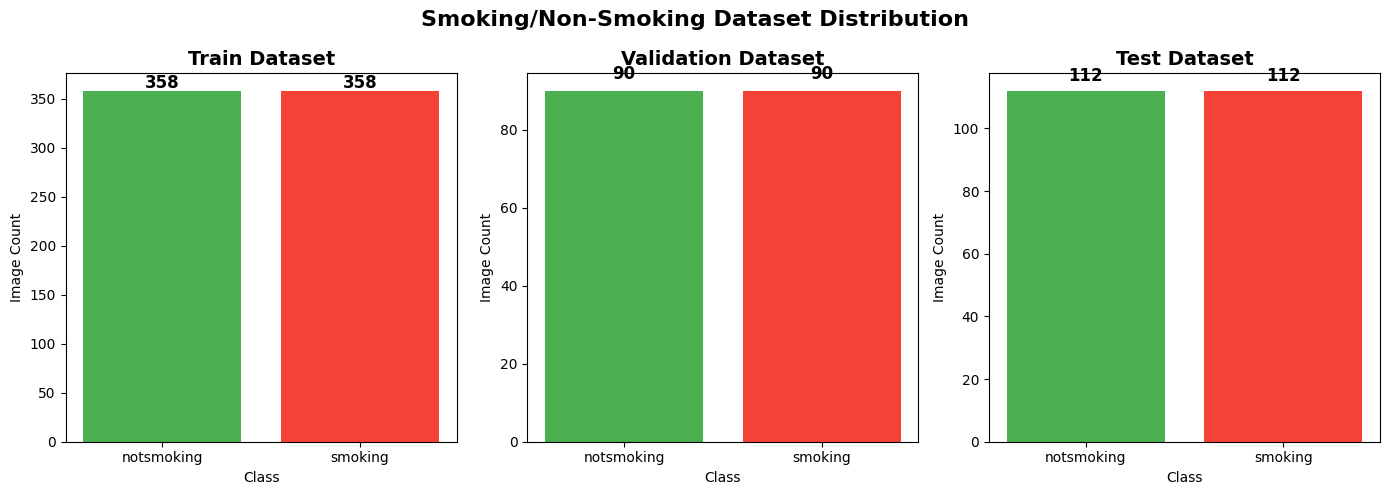

✅ class_distribution.png 저장됨


In [4]:
# 데이터 분포 시각화
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

datasets = [
    ('Train', train_counts),
    ('Validation', val_counts),
    ('Test', test_counts)
]

colors = ['#4CAF50', '#f44336']  # 녹색(notsmoking), 빨간색(smoking)

for idx, (title, counts) in enumerate(datasets):
    if counts:
        labels = list(counts.keys())
        values = list(counts.values())
        
        bars = axes[idx].bar(labels, values, color=colors[:len(labels)])
        axes[idx].set_title(f'{title} Dataset', fontsize=14, fontweight='bold')
        axes[idx].set_ylabel('Image Count')
        axes[idx].set_xlabel('Class')
        
        # 막대 위에 숫자 표시
        for bar, v in zip(bars, values):
            axes[idx].text(bar.get_x() + bar.get_width()/2, v + 3, 
                          str(v), ha='center', fontweight='bold', fontsize=12)

plt.suptitle('Smoking/Non-Smoking Dataset Distribution', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ class_distribution.png 저장됨")

In [5]:
# 요약 표 출력
print("\n" + "=" * 60)
print("데이터셋 요약 표")
print("=" * 60)
print(f"{'데이터셋':<12} {'NotSmoking':<12} {'Smoking':<12} {'Total':<10}")
print("-" * 60)
print(f"{'Train':<12} {train_counts.get('notsmoking', 0):<12} {train_counts.get('smoking', 0):<12} {sum(train_counts.values()):<10}")
print(f"{'Validation':<12} {val_counts.get('notsmoking', 0):<12} {val_counts.get('smoking', 0):<12} {sum(val_counts.values()):<10}")
print(f"{'Test':<12} {test_counts.get('notsmoking', 0):<12} {test_counts.get('smoking', 0):<12} {sum(test_counts.values()):<10}")
print("-" * 60)

total_notsmoking = train_counts.get('notsmoking', 0) + val_counts.get('notsmoking', 0) + test_counts.get('notsmoking', 0)
total_smoking = train_counts.get('smoking', 0) + val_counts.get('smoking', 0) + test_counts.get('smoking', 0)
total_all = total_notsmoking + total_smoking

print(f"{'Total':<12} {total_notsmoking:<12} {total_smoking:<12} {total_all:<10}")
print("=" * 60)


데이터셋 요약 표
데이터셋         NotSmoking   Smoking      Total     
------------------------------------------------------------
Train        358          358          716       
Validation   90           90           180       
Test         112          112          224       
------------------------------------------------------------
Total        560          560          1120      


In [6]:
import os
from PIL import Image

def find_corrupted_images(data_dir):
    """손상된 이미지 파일 찾기"""
    corrupted = []
    total = 0
    
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
                total += 1
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        img.verify()  # 이미지 검증
                except Exception as e:
                    corrupted.append((file_path, str(e)))
    
    return corrupted, total

# 손상된 이미지 찾기
corrupted_images, total_images = find_corrupted_images('dataset/organized')

print(f"\n검사 결과")
print(f"   전체 이미지: {total_images}장")
print(f"   손상된 이미지: {len(corrupted_images)}장")

if corrupted_images:
    print(f"\n손상된 이미지 목록:")
    for path, error in corrupted_images:
        print(f"   - {path}")
        print(f"     오류: {error}")
else:
    print("\n손상된 이미지가 없습니다!")


검사 결과
   전체 이미지: 1120장
   손상된 이미지: 0장

손상된 이미지가 없습니다!


In [7]:
# 경로 설정
organized_dir = 'dataset/organized'
train_dir = os.path.join(organized_dir, 'train')
val_dir = os.path.join(organized_dir, 'val')
test_dir = os.path.join(organized_dir, 'test')

def count_images_by_class(data_dir):
    """각 클래스별 이미지 수 계산"""
    result = {}
    if not os.path.exists(data_dir):
        return result
    
    for class_name in sorted(os.listdir(data_dir)):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) 
                        if f.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp'))])
            result[class_name] = count
    return result

# 각 데이터셋 통계
train_counts = count_images_by_class(train_dir)
val_counts = count_images_by_class(val_dir)
test_counts = count_images_by_class(test_dir)

print("=" * 60)
print("정리 후 데이터셋 통계")
print("=" * 60)

print(f"\n훈련 데이터 (Train)")
for class_name, count in train_counts.items():
    print(f"   - {class_name}: {count}장")
print(f"   → 총 {sum(train_counts.values())}장")

print(f"\n검증 데이터 (Validation)")
for class_name, count in val_counts.items():
    print(f"   - {class_name}: {count}장")
print(f"   → 총 {sum(val_counts.values())}장")

print(f"\n테스트 데이터 (Test)")
for class_name, count in test_counts.items():
    print(f"   - {class_name}: {count}장")
print(f"   → 총 {sum(test_counts.values())}장")

total_all = sum(train_counts.values()) + sum(val_counts.values()) + sum(test_counts.values())
print(f"\n전체 데이터: {total_all}장")
print(" 데이터 정리 완료!")

정리 후 데이터셋 통계

훈련 데이터 (Train)
   - notsmoking: 358장
   - smoking: 358장
   → 총 716장

검증 데이터 (Validation)
   - notsmoking: 90장
   - smoking: 90장
   → 총 180장

테스트 데이터 (Test)
   - notsmoking: 112장
   - smoking: 112장
   → 총 224장

전체 데이터: 1120장
 데이터 정리 완료!


In [8]:
# 훈련 데이터셋
train_ds = image_dataset_from_directory(
    os.path.join(organized_dir, 'train'),
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary',  # 중요: 0 또는 1로 라벨링
    seed=42
)

# 테스트 데이터셋 다시 정의 (organized_dir 설정이 되어있어야 함)
test_ds = image_dataset_from_directory(
    os.path.join(organized_dir, 'test'), # 테스트 데이터 경로
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary' # 이진 분류 설정
)

# 성능 최적화 적용
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


# 검증 데이터셋
val_ds = image_dataset_from_directory(
    os.path.join(organized_dir, 'val'),
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary',
    seed=42
)

# 성능 최적화
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 716 files belonging to 2 classes.
Found 224 files belonging to 2 classes.
Found 180 files belonging to 2 classes.


In [9]:
# from tensorflow.keras import regularizers
from tensorflow.keras import layers, models
# 데이터 증강 레이어 (강화)
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.1),
])

# 모델 정의 (과적합 방지 강화)
# model = Sequential([
#     # 입력층에 input_shape 명시 (summary 문제 해결)
#     layers.InputLayer(input_shape=(img_height, img_width, 3)),
    
#     # 데이터 증강
#     data_augmentation,
    
#     # 정규화
#     layers.Rescaling(1./255),
    
#     # 합성곱 블록 1
#     layers.Conv2D(32, (3, 3), activation='relu', padding='same',
#                   kernel_regularizer=regularizers.l2(0.001)),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(),
#     layers.Dropout(0.25),
    
#     # 합성곱 블록 2
#     layers.Conv2D(64, (3, 3), activation='relu', padding='same',
#                   kernel_regularizer=regularizers.l2(0.001)),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(),
#     layers.Dropout(0.25),
    
#     # 합성곱 블록 3
#     layers.Conv2D(128, (3, 3), activation='relu', padding='same',
#                   kernel_regularizer=regularizers.l2(0.001)),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(),
#     layers.Dropout(0.25),
    
#     # 분류기
#     layers.Flatten(),
#     layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
#     layers.Dropout(0.5),
#     layers.Dense(1, activation='sigmoid')
# ])


model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.BatchNormalization(), # 학습을 안정화시킵니다
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3), # 과적합 방지 (30% 노드 끄기)

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5), # 마지막 층에서 강력하게 제한
    layers.Dense(1, activation='sigmoid') # 이진 분류이므로 sigmoid
])

print("모델 정의 완료")

모델 정의 완료


c:\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,908,417 (91.20 MB)

 Trainable params: 23,907,969 (91.20 MB)

 Non-trainable params: 448 (1.75 KB)

In [11]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("모델 컴파일 완료 (learning_rate=0.0001)")

모델 컴파일 완료 (learning_rate=0.0001)


In [12]:
# 콜백 설정
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

# 학습
epochs = 50

print("모델 학습 시작")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks
)

print("학습 완료!")

모델 학습 시작
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6941 - loss: 1.0236 - val_accuracy: 0.5111 - val_loss: 10.1688 - learning_rate: 1.0000e-04
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8184 - loss: 0.4311 - val_accuracy: 0.5167 - val_loss: 4.8307 - learning_rate: 1.0000e-04
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8953 - loss: 0.2561 - val_accuracy: 0.5722 - val_loss: 2.0643 - learning_rate: 1.0000e-04
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9302 - loss: 0.2052 - val_accuracy: 0.5667 - val_loss: 1.4093 - learning_rate: 1.0000e-04
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9581 - loss: 0.1472 - val_accuracy: 0.6000 - val_loss: 0.9561 - learning_rate: 1.0000e-04
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9595 - loss: 0.1203 - val_accuracy: 0.6667 - val_loss: 0.7756 - learning_rate: 1.0000e-04
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.97

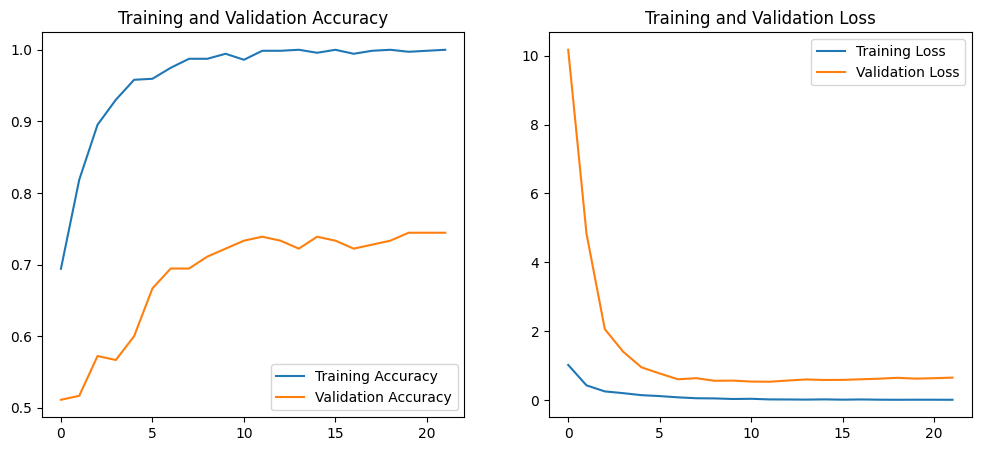

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc)) # 실제 진행된 에포크 수만큼

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [14]:
print("="*50)
print("테스트 데이터셋 결과 평가")
test_loss, test_acc = model.evaluate(test_ds)
print(f"테스트 정확도: {test_acc*100:.2f}%")

테스트 데이터셋 결과 평가
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.7589 - loss: 0.5119
테스트 정확도: 75.89%


In [15]:
model.save('smoking_detection_model.h5')
print("모델이 'smoking_detection_model.h5'로 저장되었습니다.")

모델이 'smoking_detection_model.h5'로 저장되었습니다.


In [16]:
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_smoking_status(img_path):
    # 1. 이미지 불러오기 및 전처리
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) # 배치 차원 추가
    # 모델 내부 rescaling 레이어가 없다면 /255.0을 해줘야 하지만, 
    # 우리 모델은 내부에 Rescaling 층이 있으므로 그대로 넣습니다.

    # 2. 예측
    prediction = model.predict(img_array)
    
    # 3. 결과 해석 (Sigmoid 출력값 기준)
    # 0.5보다 크면 1(smoking), 작으면 0(notsmoking)
    score = prediction[0][0]
    result = "Smoking" if score > 0.5 else "Not Smoking"
    confidence = score if score > 0.5 else 1 - score

    # 4. 시각화
    plt.imshow(img)
    plt.title(f"Prediction: {result} ({confidence*100:.2f}%)")
    plt.axis('off')
    plt.show()

    print(f"분석 결과: 이 이미지는 {confidence*100:.2f}%의 확률로 [{result}] 상태입니다.")

# 사용 예시 (본인의 테스트 이미지 경로를 넣으세요)
predict_smoking_status('/Users/iseonghun/Desktop/DLProject/dataset/DLData/Validation/Validation/smoking_0311.jpg')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/iseonghun/Desktop/DLProject/dataset/DLData/Validation/Validation/smoking_0311.jpg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step

[분류 보고서]
              precision    recall  f1-score   support

 Not Smoking       0.75      0.77      0.76       112
     Smoking       0.76      0.75      0.76       112

    accuracy                           0.76       224
   macro avg       0.76      0.76      0.76       224
weighted avg       0.76      0.76      0.76       224



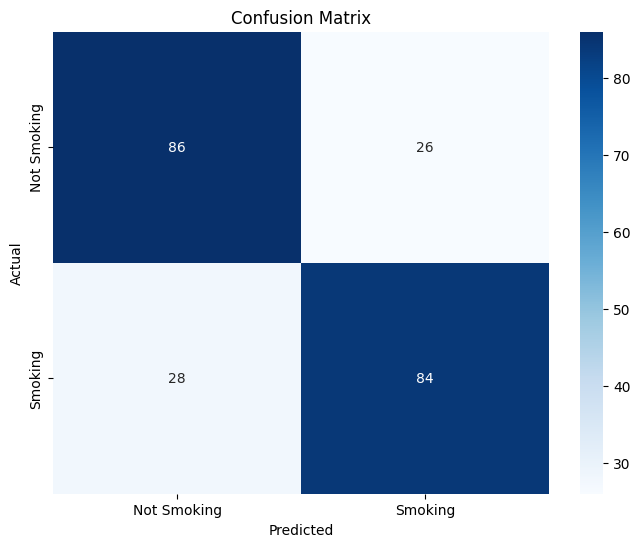

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 1. 테스트 데이터셋에서 라벨과 예측값 추출
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int))

y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()

# 2. 분류 보고서 출력 (Precision, Recall, F1-score)
print("\n[분류 보고서]")
print(classification_report(y_true, y_pred, target_names=['Not Smoking', 'Smoking']))

# 3. 혼동 행렬(Confusion Matrix) 시각화
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Smoking', 'Smoking'], 
            yticklabels=['Not Smoking', 'Smoking'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


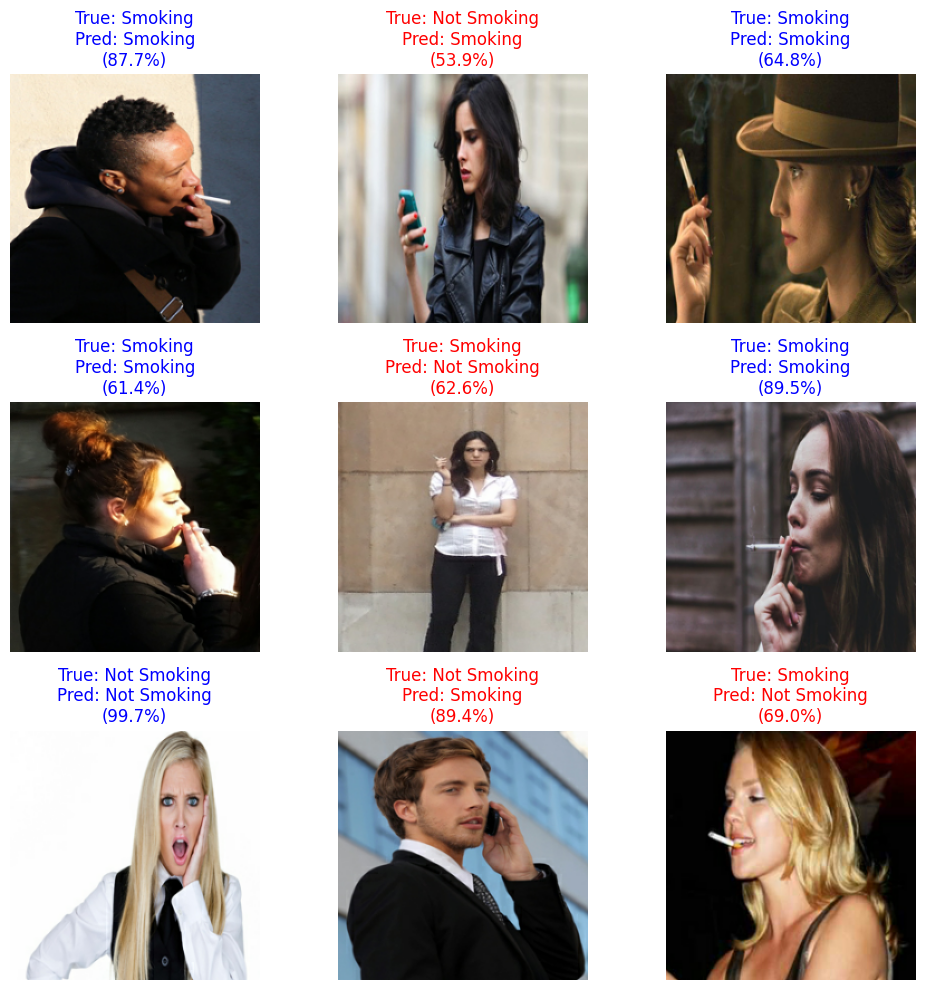

In [18]:
def visualize_multiple_predictions(dataset, num_images=9):
    plt.figure(figsize=(10, 10))
    # 데이터셋에서 한 배치 가져오기
    for images, labels in dataset.take(1):
        preds = model.predict(images)
        
        for i in range(min(num_images, len(images))):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            
            true_label = "Smoking" if labels[i] == 1 else "Not Smoking"
            pred_score = preds[i][0]
            pred_label = "Smoking" if pred_score > 0.5 else "Not Smoking"
            confidence = pred_score if pred_score > 0.5 else 1 - pred_score
            
            # 맞으면 파란색, 틀리면 빨간색 글씨
            color = 'blue' if true_label == pred_label else 'red'
            
            plt.title(f"True: {true_label}\nPred: {pred_label}\n({confidence*100:.1f}%)", color=color)
            plt.axis("off")
    plt.tight_layout()
    plt.show()

# 실행
visualize_multiple_predictions(test_ds)

In [19]:
import glob

def test_random_images(test_path_pattern, num_samples=5):
    test_images = glob.glob(test_path_pattern)
    selected_images = np.random.choice(test_images, num_samples, replace=False)
    
    print(f"\n[무작위 {num_samples}장 테스트 결과 요약]")
    print("-" * 40)
    for img_path in selected_images:
        img = image.load_img(img_path, target_size=(img_height, img_width))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        
        score = model.predict(img_array, verbose=0)[0][0]
        result = "Smoking" if score > 0.5 else "Not Smoking"
        conf = score if score > 0.5 else 1 - score
        
        print(f"파일명: {os.path.basename(img_path)} | 예측: {result} ({conf*100:.2f}%)")

# 사용 예시 (본인의 테스트 폴더 경로에 맞춰 수정하세요)
test_random_images('dataset/organized/test/smoking/*.jpg', num_samples=5)


[무작위 5장 테스트 결과 요약]
----------------------------------------
파일명: smoking_0479.jpg | 예측: Not Smoking (62.31%)
파일명: smoking_0122.jpg | 예측: Smoking (98.99%)
파일명: smoking_0477.jpg | 예측: Smoking (60.32%)
파일명: smoking_0533.jpg | 예측: Not Smoking (96.06%)
파일명: smoking_0352.jpg | 예측: Smoking (86.96%)
